Obtém o contorno paramétrico de um objeto

In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def image_contour(img):
    
    neighbor_map = [7, 7, 1, 1, 3, 3, 5, 5]
    img_pad = np.pad(img, 1, mode='constant')
    
    num_rows, num_cols = img_pad.shape
    k = 0
    row = 0
    col = 0
    # Busca do primeiro ponto do objeto
    while img_pad[row, col]==0:
        k += 1
        row = k//num_cols
        col = k - row*num_cols
        
    curr_point = (row, col)    # Ponto atual
    contour = [curr_point]     # Pontos do contorno
    starting_index = 2         # Índice do vizinho inicial a ser verificado
    while True:
        next_point, last_index = get_next_point(img_pad, curr_point, 
                                                    starting_index)
        
        starting_index = neighbor_map[last_index]
        
        if len(contour)>1:
            if next_point==contour[1] and contour[-1]==contour[0]:
                break
                
        contour.append(next_point)
        curr_point = next_point
        
    for point_index, point in enumerate(contour):
        contour[point_index] = (point[0]-1, point[1]-1)
        
    return contour

def get_next_point(img, curr_point, starting_index):
     
    nei_list = [(-1,0), (-1,1), (0,1), (1,1), 
                (1,0), (1,-1),(0,-1), (-1,-1)]
    
    curr_index = starting_index
    nei_value = 0
    while nei_value==0:
        nei_shift = nei_list[curr_index]
        nei_row = curr_point[0] + nei_shift[0]
        nei_col = curr_point[1] + nei_shift[1]
        nei_value = img[nei_row, nei_col]
        if nei_value==1:
            return (nei_row, nei_col), curr_index
        else:
            curr_index = (curr_index+1)%8

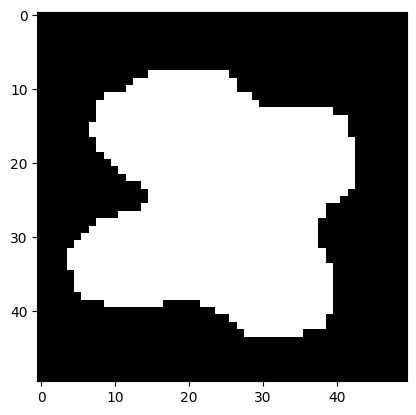

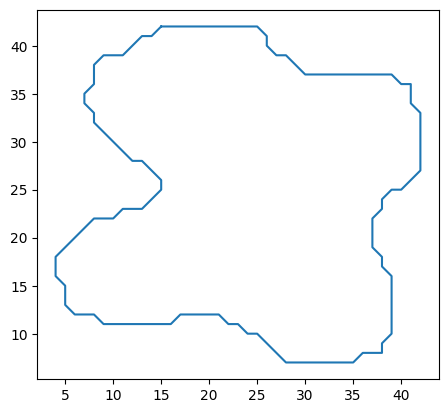

In [92]:
img = plt.imread('blob.tiff')
img = img>0
plt.imshow(img, 'gray')

cont = image_contour(img)
# Transforma o contorno em um array numpy
cont = np.array(cont)

plt.figure()
plt.subplot(111, aspect='equal')
# Plota os pontos de contorno, precisamos inverter os valores em y porque,
# na imagem, a origem está no ponto superior esquerdo
plt.plot(cont[:,1], img.shape[0]-cont[:,0])

Cálculo da curvatura ao longo do contorno do objeto

In [93]:
def curvature(contour):
    n = len(contour)
    curvature = np.zeros(n)
    for i in range(1, n-1):
        x_i, y_i = contour[i]
        x_im1, y_im1 = contour[i-1]
        x_ip1, y_ip1 = contour[i+1]
        num = 2*(y_im1 - 2*y_i + y_ip1)**2 + 2*(x_im1 - 2*x_i + x_ip1)**2
        den = ( (x_im1-x_ip1)**2 + (y_im1-y_ip1)**2 )**(3/2)
        curvature[i] = num / den
    return curvature

Suaviza a curvatura utilizando um filtro de média móvel com tamanho k.

In [94]:
def smooth_curvature(curvature, k=5):
    '''Suaviza a curvatura utilizando um filtro de média móvel com tamanho k.'''
    suavizada = np.convolve(curvature, np.ones(k)/k, mode='same')
    return suavizada


Gráfico da curvatura

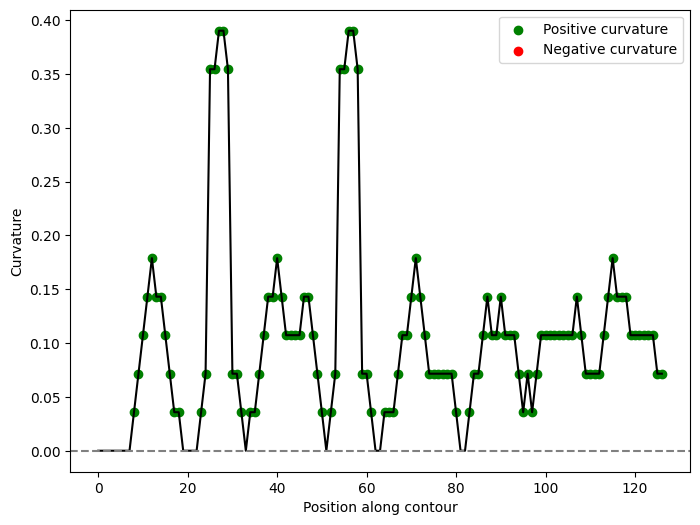

[  8   9  10  11  12  13  14  15  16  17  18  23  24  25  26  27  28  29
  30  31  32  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  52  53  54  55  56  57  58  59  60  61  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
[]


In [95]:
curv = curvature(cont)
suav = smooth_curvature(curv, k =5)

sign = np.sign(suav)
pos = np.where(sign == 1)[0]
neg = np.where(sign == -1)[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(suav, color='black')
ax.scatter(pos, suav[pos], color='green', label='Positive curvature')
ax.scatter(neg, suav[neg], color='red', label='Negative curvature')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Position along contour')
ax.set_ylabel('Curvature')
ax.legend()
plt.show()

print(pos)
print(neg)

Propriedas para caracterizar o objeto

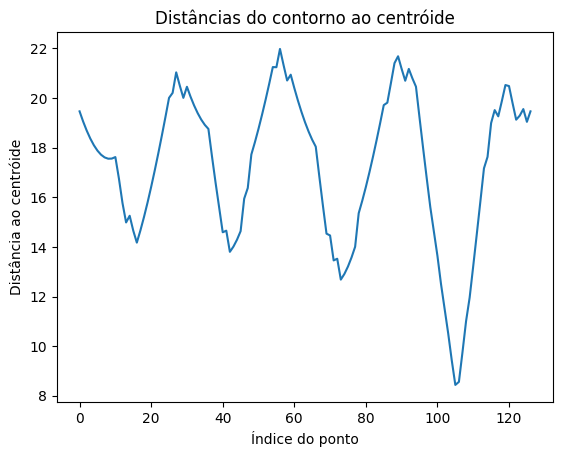

In [96]:
#Distância do centroide

def centroid_distance(cont):
    n = len(cont)
    centroid = np.mean(cont, axis=0)
    distances = np.zeros(n)
    for i in range(n):
        x_i, y_i = cont[i]
        x_c, y_c = centroid
        distances[i] = np.sqrt((x_i - x_c)**2 + (y_i - y_c)**2)
    return distances, centroid

contour_distances, centroid = centroid_distance(cont)
plt.plot(contour_distances)
plt.xlabel('Índice do ponto')
plt.ylabel('Distância ao centróide')
plt.title('Distâncias do contorno ao centróide')
plt.show()


In [97]:
#Perimetro do objeto

def perimeter(contour):
    n = len(contour)
    p = 0
    for i in range(n):
        p += np.linalg.norm(contour[i] - contour[(i+1)%n])
    return p

per = perimeter(cont)
print("Perimetro: ", per)

Perimetro:  143.39696961967


In [98]:
#Curvatura Média
def midCurv(img, k=5):
    mean_curv = np.mean(curv)

    return mean_curv

print("Curvatura média: ", midCurv(img))

Curvatura média:  0.10255824489878136


In [99]:
#Excentricidade
def excen(contour):
    distances, centroid = centroid_distance(contour)
    max_distance = np.max(distances)
    
    n = len(contour)
    max_chord = 0
    for i in range(n):
        for j in range(i+1, n):
            chord = np.linalg.norm(contour[i] - contour[j])
            if chord > max_chord:
                max_chord = chord
    
    return max_distance / max_chord

print("Excentricidade: ", excen(cont))

Excentricidade:  0.5145649133997046


In [100]:
#Valor máximo
max_curvature = np.max(curv)
print("Curvatura Máxima: ", max_curvature)


Curvatura Máxima:  1.414213562373095
